In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Intuition behind Derivatives

In [20]:
def f(x):
    return 3*x**2 - 4*x + 5

In [21]:
f(3.0)


20.0

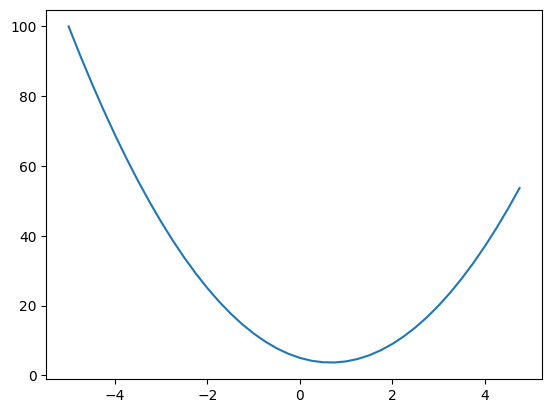

In [22]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

## Differentiation for Univariate Functions

### Definition: *Derivative*

For $h \gt 0$ the *derivative* of $f$ at $x$ is defined as the limit

$$
\frac{df}{dx} := \lim_{h \to 0} \frac{ f(x + h) - f(x) }{ h }
$$


In [23]:
# For f(x) at x = 2/3:
h = 0.000001
x = 2/3
print((f(x + h) - f(x)) / h)

2.999378523327323e-06


## Partial Differentiation and Gradients

### Definition: *Partial Derivative*

For a function $f : \mathbb{R}^2 \to \mathbb{R}, \, \mathbf{x} \mapsto f(\mathbf{x}), \mathbf{x} \in \mathbb{R}^n$ of $n$ variables $x_1, \dots, x_n$ we define the *partial derivative* as 

$$
\frac{\partial f}{\partial x_1} = \lim_{h \to 0} \frac{ f(x_1 + h, x_2, \dots, x_n ) - f( \mathbf{x} ) }{ h }
$$
$$
\vdots
$$
$$
\frac{\partial f}{\partial x_n} = \lim_{h \to 0} \frac{ f(x_1, x_2, \dots, x_n + h ) - f( \mathbf{x} ) }{ h }
$$

and collect them in the new row vector

$$
\nabla_x f = \text{grad} f = \frac{\partial f}{\partial \mathbf{x}} =  \begin{bmatrix}
\frac{\partial f}{\partial x_1} & \frac{\partial f}{\partial x_2} & \dots & \frac{\partial f}{\partial x_n}
\end{bmatrix} \in \mathbb{R}^{1 \times n}
$$


In [24]:
# Multivariate function f(a, b, x) = a * b + c  

def f(a, b, c):
    return a*b + c

a = 2.0
b = -3.0
c = 10.0
d = f(a, b, c)
print(d)

4.0


In [25]:
# Partial derivatives for f with respect to a

h = 0.00001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = f(a, b, c)
d2 = f(a+h, b, c)

print("d1", d1)
print("d2", d2)
print("Derivative w. r. to a =", ((d2 - d1) / h))

d1 4.0
d2 3.9999699999999994
Derivative w. r. to a = -3.000000000064062


*The partial derivative with respect to $a$ of $f$ at $a=2, b=-3, c=10$ is -3.*

*Proving this with the analytical approach gives us $\frac{\partial f}{\partial a} = b$.*

In [26]:
# Partial derivatis for f with respect to b & c

h = 0.00001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d3 = f(a, b+h, c)
d4 = f(a, b, c+h)

print("d3", d3)
print("Derivative w. r. to b =", ((d3 - d1) / h))
print("d3", d4)
print("Derivative w. r. to c =", ((d4 - d1) / h))

d3 4.00002
Derivative w. r. to b = 2.0000000000131024
d3 4.00001
Derivative w. r. to c = 0.9999999999621422


$$\frac{\partial f}{\partial b} = a$$

$$\frac{\partial f}{\partial c} = 1$$

# Neural Networks

In [27]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"{self.label if self.label is not None else 'NoName'}: {self.data}"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def copy(self):
        return Value(self.data, self._prev, self._op, self.label)

In [79]:
from graphviz import Digraph

def trace(root):
    nodes , edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Manual Backpropagation for the Function

$$
L(a, b, c, d) = ((a \times b) + c) \times d
$$

Or

$$
L(a, b, c, d) = L(f(e(a, b), c), d), 
$$

with

$$
e(a, b) = a \times b, 
$$
$$
f(e, c) = e + c, 
$$
$$
L(f, d) = f \times d
$$

### Building the Computation Graph

In [29]:
# Input
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10, label="c")
d = Value(-2.0, label="d")

# Itermetiate nodes
e = a * b; e.label = "e"
f = e + c; f.label = "f"
L = f * d; L.label = "L"

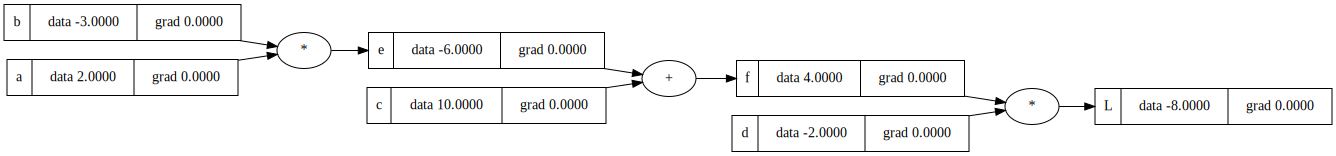

In [30]:
draw_dot(L)

### Backpropagation Step 1: **L**

The derivative of L with respect to L is 1.
$$ \frac{\partial L}{\partial L} = 1.0 $$
$$ \frac{\partial \text{ dependant var}\ }{\partial \text{ independant var}\ } = derivative $$

0.9999999999976694


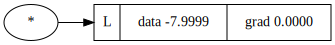

In [88]:
def partial_using_lim(dependent_var, independent_var, h=1e-4):
    list_of_values = [dependent_var.copy()]
    val1 = list_of_values[0].data

    def _copy_graph(current_value, independent_var, list_of_values):
        children = list(current_value._prev)
        if current_value.label == independent_var.label:
            current_value.data += h
            current_value._prev = set()
            children = []
        elif children != []:
            order = [1, 0]
            if children[0]._prev == set():
                order = [0, 1]
            new_children = [children[order[i]].copy() for i in range(2)]
            list_of_values.append(new_children[0])
            list_of_values.append(new_children[1])
            current_value._prev = set(new_children)
            list_of_values = _copy_graph(new_children[0], independent_var, list_of_values)
            list_of_values = _copy_graph(new_children[1], independent_var, list_of_values) 
        return list_of_values
    
    def _update_graph(value):
        if value._prev != set():
            children = list(value._prev)
            _update_graph(children[0])
            _update_graph(children[1])
            if value._op == "*":
                value.data = children[0].data * children[1].data
            else:
                value.data = children[0].data + children[1].data
    
    list_of_values = _copy_graph(list_of_values[0], independent_var, list_of_values)
    _update_graph(list_of_values[0])
    val2 = list_of_values[0].data

    return draw_dot(list_of_values[0]), ((val2 - val1) / h)

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10, label="c")
d = Value(-2.0, label="d")
# Itermediate nodes
e = a * b; e.label = "e"
f = e + c; f.label = "f"
L = f * d; L.label = "L"
L1 = L.data

dot, derivative = partial_using_lim(L, L)
print(derivative)
dot


In [33]:
class Graph:
    def __init__(self):
        value_list = []

    def add_value(value, label=""):
        pass

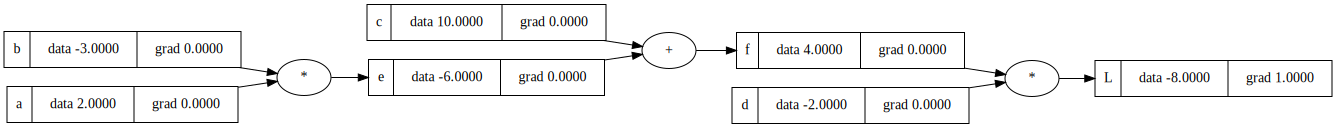

In [34]:
L.grad = 1.0
draw_dot(L)

### Backpropagation Step 2: **d** & **f**

Knowing that $L(f, d) = f \times d$, we can calculate the derivatives simply as

$$
\frac{ \partial L }{ \partial d} = f
$$

and 

$$
\frac{\partial L}{\partial f} = d
$$

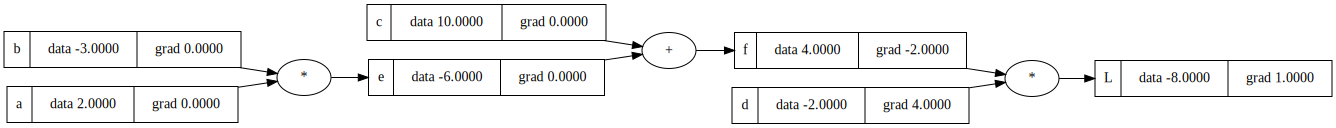

In [35]:
d.grad = f.data
f.grad = d.data
draw_dot(L)

### Backpropagation Step 3: **c** & **e**

$$
\frac{ \partial L }{ c } = 
$$

$$
\frac{ \partial L }{ e } = 
$$